2025-03-29 18:09:44.906386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743289784.927021 1440232 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743289784.933435 1440232 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-29 18:09:44.956202: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors :
/usr/bin/ld: cannot find -lnvrtc: No such file or directory
collect2: error: ld returned 1 exit status

OK
[pyKeOps] Compiling nvrtc binder for python ... 
[KeOps] Warning : There were warnings or errors :
/usr/bin/ld: cannot find -lnvrtc: No such file or directory
collect2: error: ld returned 1 exit status

OK


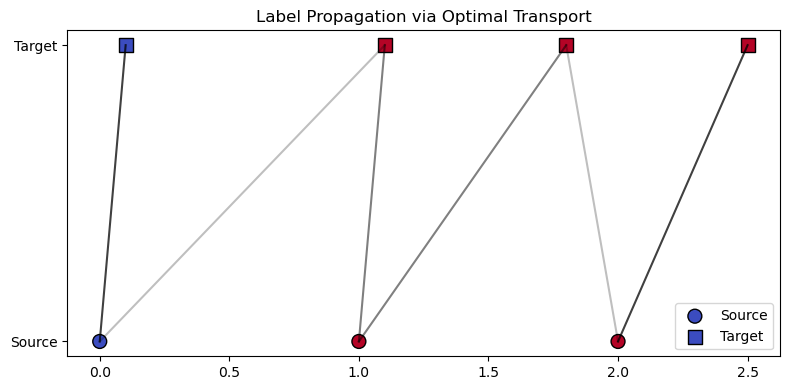

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import ot  # Requires: pip install POT
from train_model import *

import torch
from torch.utils.data import DataLoader, random_split, Subset
import torch.optim as optim
from train_model import *
from util import *
from dataset import *
from ot_util import *
from model import *
import copy
import csv
import os 
from da_algo import get_pseudo_labels


# --- Step 1: Create toy source and target data ---
X_s = np.array([[0.0], [1.0], [2.0]])           # 3 source points
y_s = np.array([0, 1, 1])                       # Their labels

X_t = np.array([[0.1], [1.1], [1.8], [2.5]])    # 4 unlabeled target points

# --- Step 2: Compute OT plan ---
a = np.ones(len(X_s)) / len(X_s)               # uniform source weights
b = np.ones(len(X_t)) / len(X_t)               # uniform target weights
M = ot.dist(X_s, X_t)                           # cost matrix (L2 distance)
plan = ot.emd(a, b, M)                          # optimal transport plan

# --- Step 3: Propagate labels using the plan ---
classes = np.unique(y_s)
D1 = np.zeros((len(classes), len(y_s)))        # one-hot matrix of source labels
for c in classes:
    D1[int(c), y_s == c] = 1

transp_logits = np.dot(D1, plan).T             # shape: [target x classes]
pseudo_labels = np.argmax(transp_logits, axis=1)

# --- Step 4: Plot ---
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X_s, np.zeros_like(X_s), c=y_s, cmap='coolwarm', s=100, label='Source', edgecolors='k')
ax.scatter(X_t, np.ones_like(X_t), c=pseudo_labels, cmap='coolwarm', marker='s', s=100, label='Target', edgecolors='k')

# Draw OT connections
for i in range(len(X_s)):
    for j in range(len(X_t)):
        if plan[i, j] > 0:
            alpha = plan[i, j] * len(X_s)
            ax.plot([X_s[i], X_t[j]], [0, 1], 'k-', alpha=alpha)

ax.set_yticks([0, 1])
ax.set_yticklabels(['Source', 'Target'])
ax.set_title('Label Propagation via Optimal Transport')
ax.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
import numpy as np
from scipy.stats import special_ortho_group

def sample_gaussian_params(d, min_var=0.05, max_var=0.1):
    """Sample a mean vector and PSD covariance matrix."""
    mu = np.random.randn(d)
    
    # Sample diagonal eigenvalues uniformly
    D = np.diag(np.random.uniform(min_var, max_var, size=d))
    
    # Haar random orthogonal matrix (rotation)
    U = special_ortho_group.rvs(dim=d)
    
    # Compose full covariance matrix: Σ = U D Uᵀ
    Sigma = U @ D @ U.T
    return mu, Sigma

def interpolate_gaussian_params(mu0, muT, Sigma0, SigmaT, t, T):
    """Interpolate mean and covariance at time step t."""
    alpha = t / T
    mu_t = (1 - alpha) * mu0 + alpha * muT
    Sigma_t = (1 - alpha) * Sigma0 + alpha * SigmaT
    return mu_t, Sigma_t

def sample_domain_data(mu, Sigma, n_samples):
    """Sample n_samples from a Gaussian."""
    return np.random.multivariate_normal(mu, Sigma, size=n_samples)

def generate_gaussian_domain_sequence(
    d=100, N_labeled=500, N_unlabeled=5000, T=10,
    min_var=0.05, max_var=0.1, seed=42
):
    np.random.seed(seed)

    # Generate parameters for each class and each domain end (0 = source, T = target)
    params = {}
    for cls in [-1, +1]:
        mu0, Sigma0 = sample_gaussian_params(d, min_var, max_var)
        muT, SigmaT = sample_gaussian_params(d, min_var, max_var)
        params[cls] = {"mu0": mu0, "muT": muT, "Sigma0": Sigma0, "SigmaT": SigmaT}

    # Sample labeled data from source (t = 0)
    X_labeled = []
    y_labeled = []
    for cls in [-1, +1]:
        X = sample_domain_data(params[cls]["mu0"], params[cls]["Sigma0"], N_labeled // 2)
        X_labeled.append(X)
        y_labeled += [cls] * (N_labeled // 2)
    X_labeled = np.vstack(X_labeled)
    y_labeled = np.array(y_labeled)

    # Sample unlabeled data from interpolated domains
    unlabeled_domains = []
    for t in range(1, T + 1):
        Xt = []
        yt = []
        for cls in [-1, +1]:
            mu_t, Sigma_t = interpolate_gaussian_params(
                params[cls]["mu0"], params[cls]["muT"],
                params[cls]["Sigma0"], params[cls]["SigmaT"],
                t, T
            )
            X = sample_domain_data(mu_t, Sigma_t, N_unlabeled // 2)
            Xt.append(X)
            yt += [cls] * (N_unlabeled // 2)
        Xt = np.vstack(Xt)
        yt = np.array(yt)
        unlabeled_domains.append((Xt, yt))

    return X_labeled, y_labeled, unlabeled_domains

# Example usage:
if __name__ == "__main__":
    X_source, y_source, domains = generate_gaussian_domain_sequence()
    X_target, y_target = domains[-1]

    print("Source:", X_source.shape, y_source.shape)
    print("Target:", X_target.shape, y_target.shape)


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_domain_progression(X_source, y_source, domains, domain_indices=None, titles=None):
    """
    Plot 2D PCA projection of selected domains.
    
    Args:
        X_source (np.ndarray): Source domain data
        y_source (np.ndarray): Source labels
        domains (list of (X, y)): List of intermediate/target domains
        domain_indices (list of int): Indices of domains to plot (optional)
        titles (list of str): Custom titles for subplots (optional)
    """
    if domain_indices is None:
        domain_indices = [0, len(domains) // 2, len(domains) - 1]
    if titles is None:
        titles = ['Source Domain (t=0)', 'Midpoint Domain', 'Target Domain (t=T)']

    # Combine all data for consistent PCA projection
    all_X = np.vstack([X_source] + [domains[i][0] for i in domain_indices])
    scaler = StandardScaler()
    all_X_scaled = scaler.fit_transform(all_X)
    
    pca = PCA(n_components=2)
    pca.fit(all_X_scaled)

    plt.figure(figsize=(15, 4))

    for i, idx in enumerate(domain_indices):
        plt.subplot(1, len(domain_indices), i+1)
        if idx == 0:
            X_vis = pca.transform(scaler.transform(X_source))
            y_vis = y_source
        else:
            X_vis = pca.transform(scaler.transform(domains[idx][0]))
            y_vis = domains[idx][1]

        plt.scatter(X_vis[y_vis == -1, 0], X_vis[y_vis == -1, 1], alpha=0.5, label='Class -1')
        plt.scatter(X_vis[y_vis == +1, 0], X_vis[y_vis == +1, 1], alpha=0.5, label='Class +1')
        plt.title(titles[i])
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


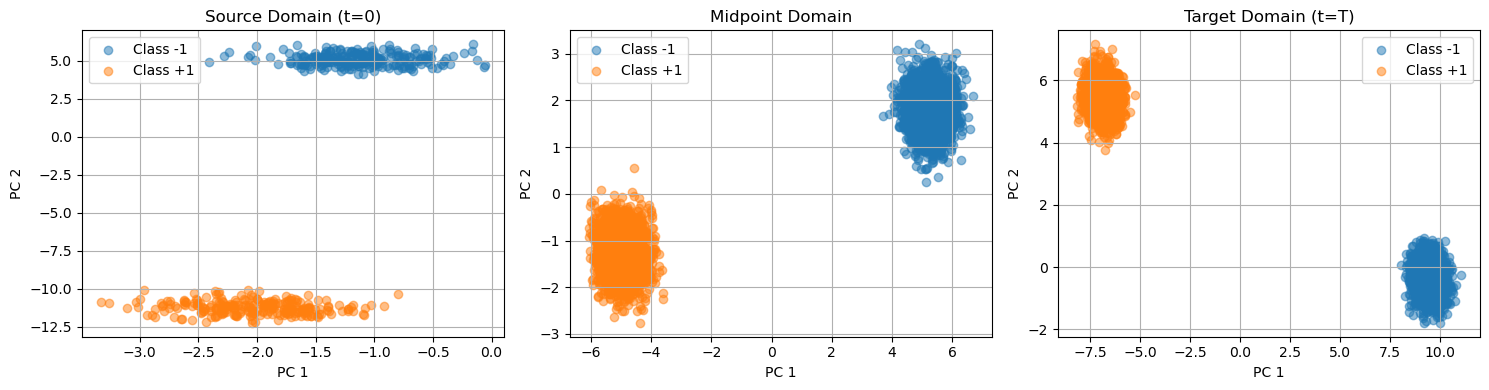

In [ ]:
X_source, y_source, domains = generate_gaussian_domain_sequence()
plot_domain_progression(X_source, y_source, domains)


In [ ]:
from torch.utils.data import Dataset
import torch

class GaussianDomainDataset(Dataset):
    def __init__(self, X, y=None, weight=None, transform=None):
        self.data = torch.tensor(X, dtype=torch.float32)
        self.targets = torch.tensor(y, dtype=torch.long) if y is not None else None
        self.weight = torch.tensor(weight, dtype=torch.float32) if weight is not None else torch.ones(len(X))
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index] if self.targets is not None else -1
        w = self.weight[index]
        if self.transform:
            x = self.transform(x)
        return x, y, w

    def __len__(self):
        return len(self.data)



import torch.nn as nn
import torch.nn.functional as F

class MLPClassifier(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=256, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


In [ ]:
def self_train(args, source_model, datasets, epochs=10):
    steps = len(datasets)
    teacher = source_model
    targetset = datasets[-1]
        
    targetloader = DataLoader(targetset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
    print("------------Direct adapt performance----------")
    _, direct_acc = test(targetloader, teacher)

    for i in range(steps):
        print(f"--------Training on the {i}th domain--------")
        trainset = datasets[i]
        ogloader = DataLoader(trainset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
                
        _, _ = test(targetloader, teacher)

        # Pseudo-label + filter
        train_labs, train_idx = get_pseudo_labels(ogloader, teacher, confidence_q=0.1)

        # Convert to EncodeDataset
        if torch.is_tensor(trainset.data):
            data = trainset.data.cpu().detach().numpy()
        else:
            data = trainset.data

        if torch.is_tensor(trainset.weight):
            weight = trainset.weight.cpu().detach().numpy()
        else:
            weight = trainset.weight

        trainset = GaussianDomainDataset(data, train_labs, weight)
        filter_trainset = Subset(trainset, train_idx)

        print("Trainset size: " + str(len(filter_trainset)))

        trainloader = DataLoader(filter_trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)

        # Train student
        student = copy.deepcopy(teacher)
        optimizer = optim.Adam(student.parameters(), lr=args.lr, weight_decay=1e-4)

        for epoch in range(1, epochs + 1):
            train(epoch, trainloader, student, optimizer)

        print("------------Performance on the current domain----------")
        test(trainloader, student)
        print("------------Performance on the target domain----------")
        _, st_acc = test(targetloader, student)

        teacher = copy.deepcopy(student)

    return direct_acc, st_acc


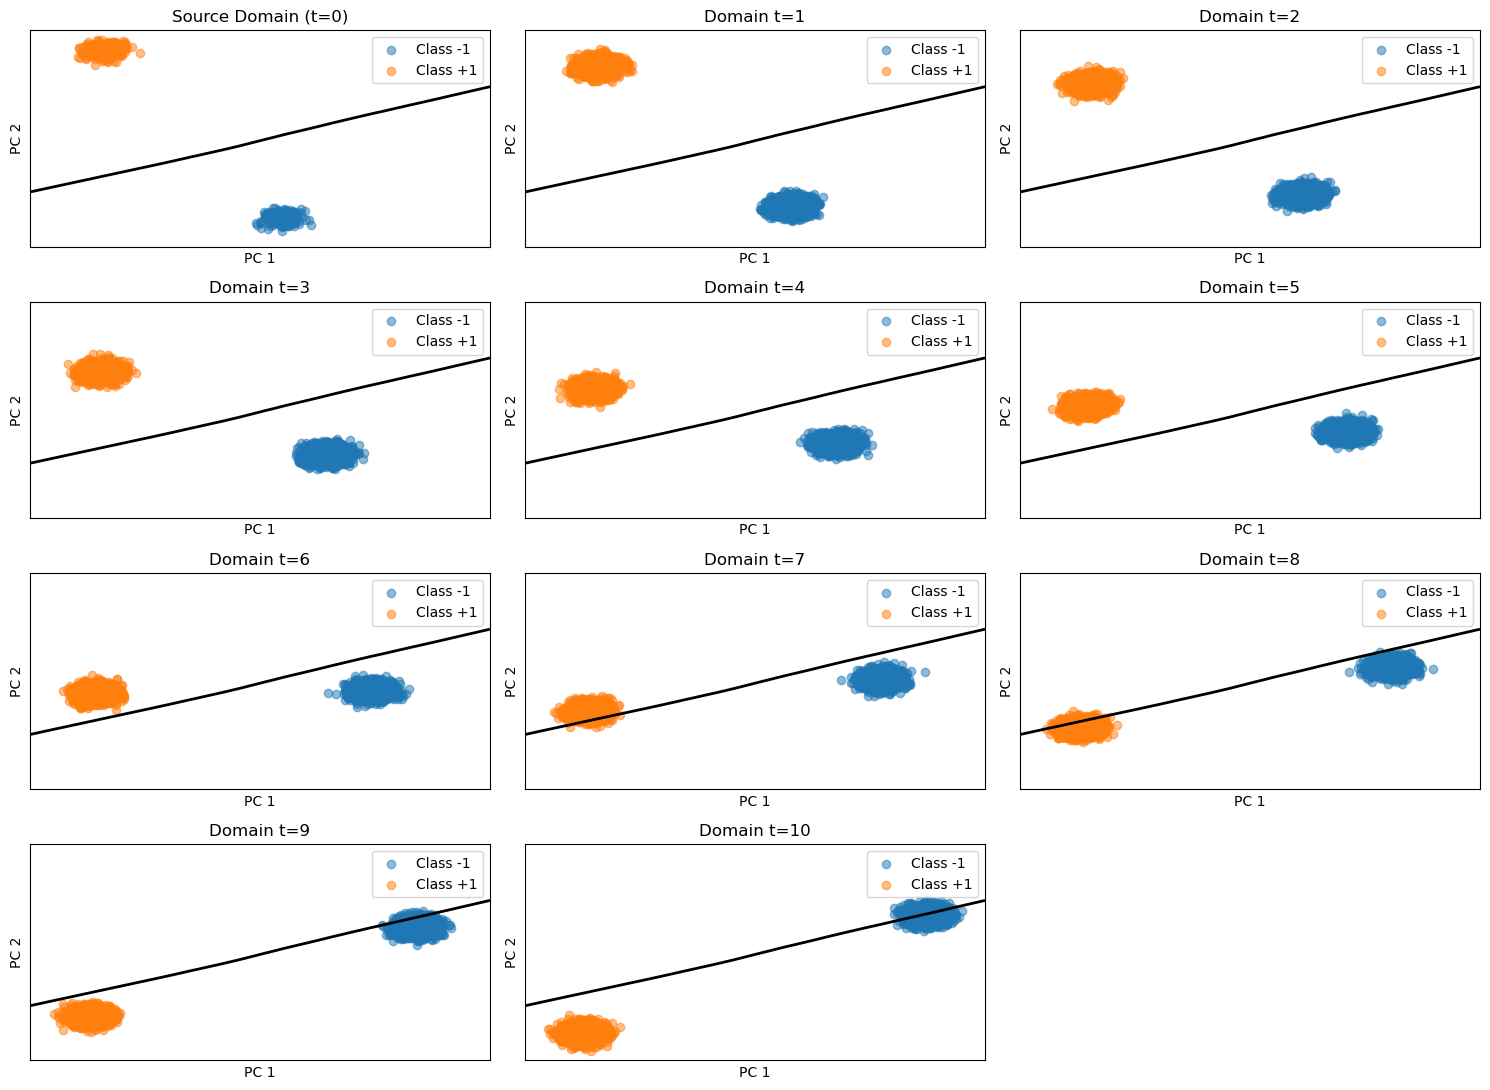

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F

# Re-generate or reuse your Gaussian domain sequence
X_source, y_source, domains = generate_gaussian_domain_sequence()
X_all = np.vstack([X_source] + [X for (X, _) in domains])

# Fit StandardScaler and PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)
pca = PCA(n_components=2)
pca.fit(X_scaled)

# Train MLPClassifier on source data
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=256, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

model = MLPClassifier(input_dim=100)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Convert labels to 0/1
y_source_binary = (y_source == 1).astype(int)
X_tensor = torch.tensor(X_source, dtype=torch.float32)
y_tensor = torch.tensor(y_source_binary, dtype=torch.long)

# Train
for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    logits = model(X_tensor)
    loss = loss_fn(logits, y_tensor)
    loss.backward()
    optimizer.step()

# Set up the grid
X_proj = pca.transform(X_scaled)
x_min, x_max = X_proj[:, 0].min() - 1, X_proj[:, 0].max() + 1
y_min, y_max = X_proj[:, 1].min() - 1, X_proj[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))
grid_2d = np.c_[xx.ravel(), yy.ravel()]
grid_highD = scaler.inverse_transform(pca.inverse_transform(grid_2d))
grid_tensor = torch.tensor(grid_highD, dtype=torch.float32)

# Predict probabilities
model.eval()
with torch.no_grad():
    logits = model(grid_tensor)
    probs = torch.softmax(logits, dim=1)[:, 1].numpy()
probs = probs.reshape(xx.shape)

# Plot decision boundaries across all domains
n_domains = len(domains)
plt.figure(figsize=(15, 3 * (n_domains + 1) // 3))

for i in range(n_domains + 1):
    plt.subplot((n_domains + 1) // 3 + 1, 3, i + 1)

    if i == 0:
        X_vis = X_source
        y_vis = y_source
        title = "Source Domain (t=0)"
    else:
        X_vis, y_vis = domains[i - 1]
        title = f"Domain t={i}"

    X_vis_2d = pca.transform(scaler.transform(X_vis))

    # Plot decision boundary (0.5 contour)
    plt.contour(xx, yy, probs, levels=[0.5], colors='black', linewidths=2)

    # Plot data
    plt.scatter(X_vis_2d[y_vis == 0, 0], X_vis_2d[y_vis == 0, 1], alpha=0.5, label='Class -1')
    plt.scatter(X_vis_2d[y_vis == +1, 0], X_vis_2d[y_vis == +1, 1], alpha=0.5, label='Class +1')
    plt.title(title)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.xticks([])
    plt.yticks([])
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
y_vis

array([0, 0, 0, ..., 1, 1, 1])

------------Direct adapt performance----------
Accuracy: 0.0352
--------Training on the 0th domain--------
Accuracy: 0.0352
Trainset size: 4500
------------Performance on the target domain----------
Accuracy: 0.2782


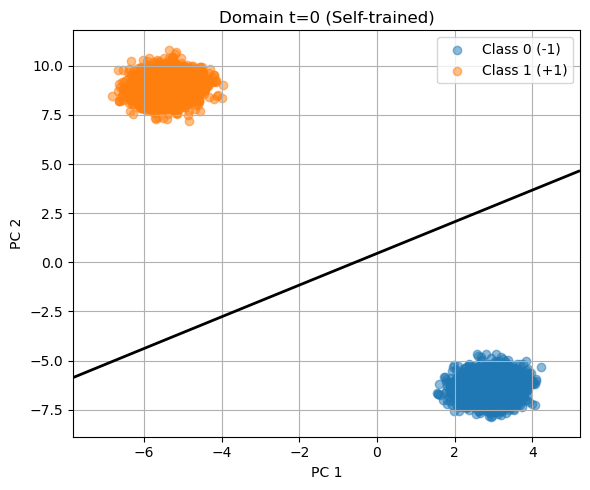

--------Training on the 1th domain--------
Accuracy: 0.2782
Trainset size: 4498
------------Performance on the target domain----------
Accuracy: 0.9658


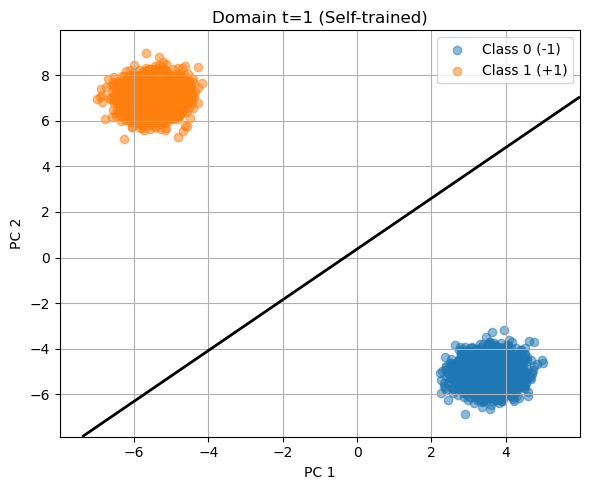

--------Training on the 2th domain--------
Accuracy: 0.9658
Trainset size: 4499
------------Performance on the target domain----------
Accuracy: 1.0000


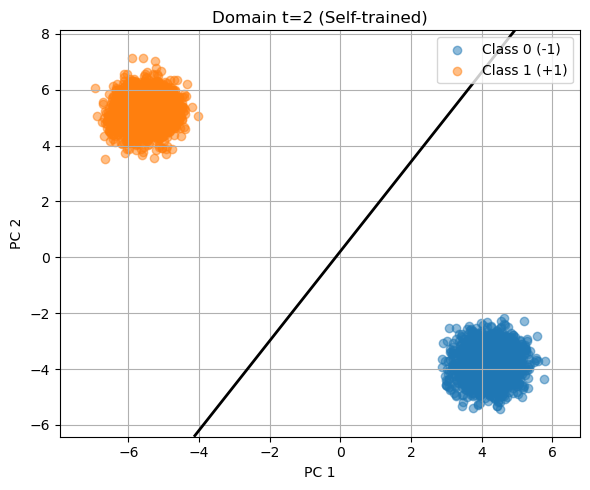

--------Training on the 3th domain--------
Accuracy: 1.0000
Trainset size: 4493
------------Performance on the target domain----------
Accuracy: 1.0000


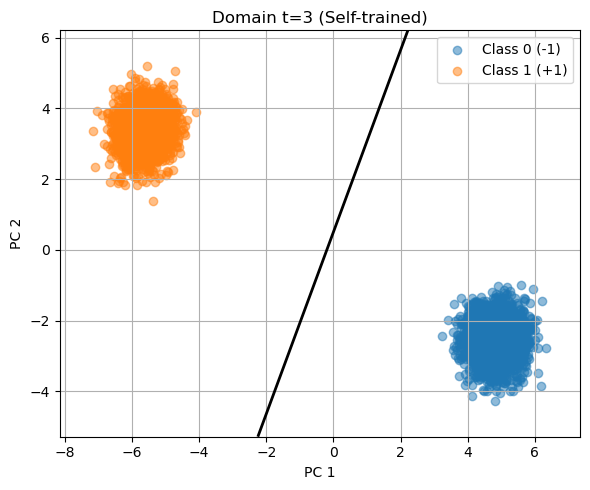

--------Training on the 4th domain--------
Accuracy: 1.0000
Trainset size: 4498
------------Performance on the target domain----------
Accuracy: 1.0000


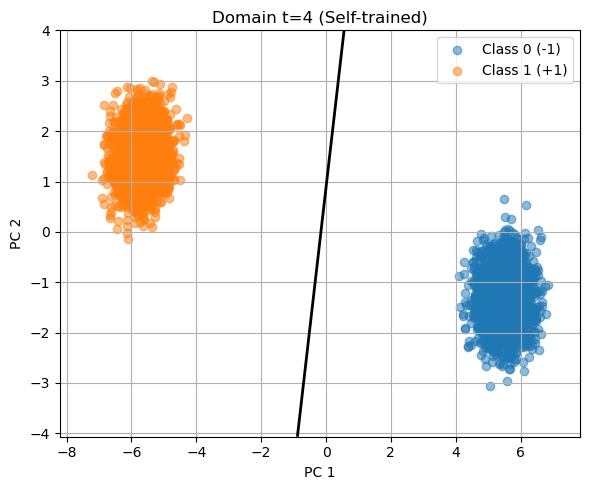

--------Training on the 5th domain--------
Accuracy: 1.0000
Trainset size: 4498
------------Performance on the target domain----------
Accuracy: 1.0000


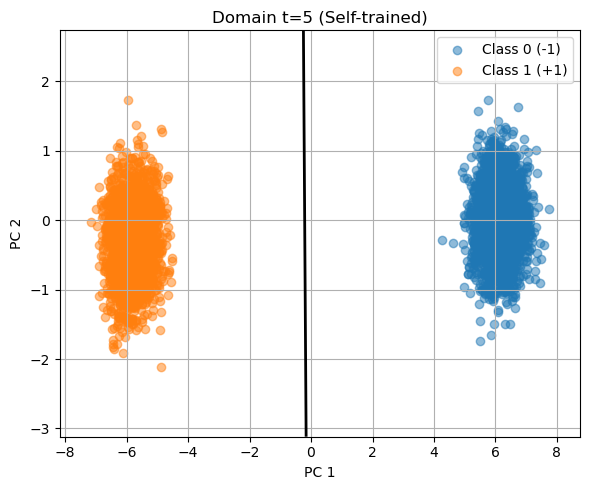

--------Training on the 6th domain--------
Accuracy: 1.0000
Trainset size: 4497
------------Performance on the target domain----------
Accuracy: 1.0000


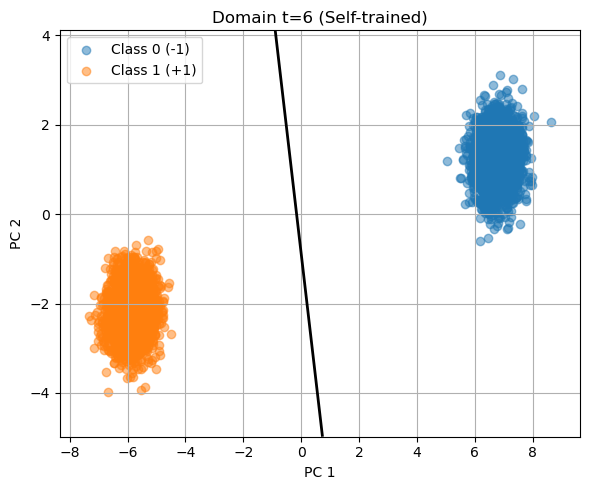

--------Training on the 7th domain--------
Accuracy: 1.0000
Trainset size: 4483
------------Performance on the target domain----------
Accuracy: 1.0000


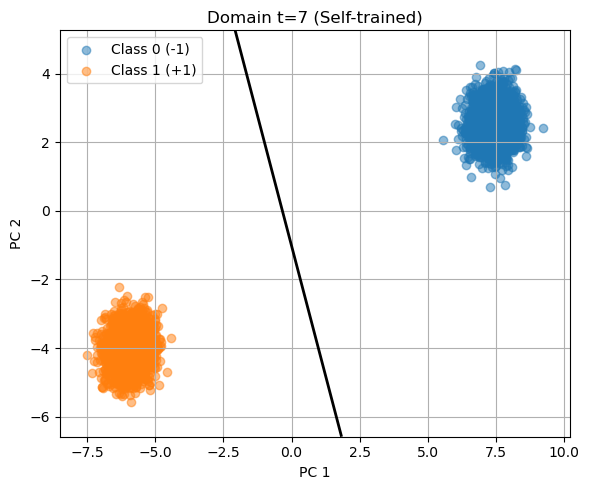

--------Training on the 8th domain--------
Accuracy: 1.0000
Trainset size: 4491
------------Performance on the target domain----------
Accuracy: 1.0000


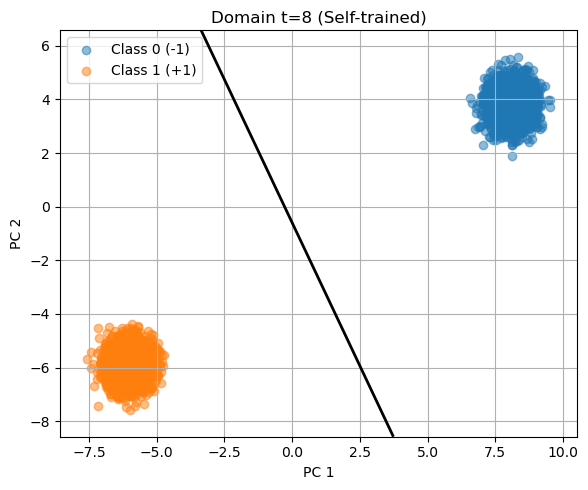

--------Training on the 9th domain--------
Accuracy: 1.0000
Trainset size: 4497
------------Performance on the target domain----------
Accuracy: 1.0000


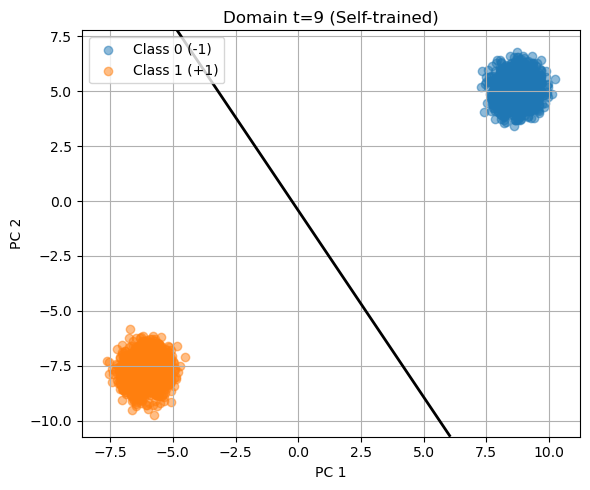

Initial accuracy: 0.0352
Final self-trained accuracy: 1.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from types import SimpleNamespace
import copy

# --- Data generation utilities (same as you provided) ---
from scipy.stats import special_ortho_group

def sample_gaussian_params(d, min_var=0.05, max_var=0.1):
    mu = np.random.randn(d)
    D = np.diag(np.random.uniform(min_var, max_var, size=d))
    U = special_ortho_group.rvs(dim=d)
    Sigma = U @ D @ U.T
    return mu, Sigma

def interpolate_gaussian_params(mu0, muT, Sigma0, SigmaT, t, T):
    alpha = t / T
    mu_t = (1 - alpha) * mu0 + alpha * muT
    Sigma_t = (1 - alpha) * Sigma0 + alpha * SigmaT
    return mu_t, Sigma_t

def sample_domain_data(mu, Sigma, n_samples):
    return np.random.multivariate_normal(mu, Sigma, size=n_samples)

def generate_gaussian_domain_sequence(d=100, N_labeled=500, N_unlabeled=5000, T=10,
                                      min_var=0.05, max_var=0.1, seed=42):
    np.random.seed(seed)
    params = {}
    for cls in [-1, +1]:
        mu0, Sigma0 = sample_gaussian_params(d, min_var, max_var)
        muT, SigmaT = sample_gaussian_params(d, min_var, max_var)
        params[cls] = {"mu0": mu0, "muT": muT, "Sigma0": Sigma0, "SigmaT": SigmaT}

    X_labeled, y_labeled = [], []
    for cls in [-1, +1]:
        X = sample_domain_data(params[cls]["mu0"], params[cls]["Sigma0"], N_labeled // 2)
        X_labeled.append(X)
        y_labeled += [cls] * (N_labeled // 2)
    X_labeled = np.vstack(X_labeled)
    y_labeled = np.array(y_labeled)

    unlabeled_domains = []
    for t in range(1, T + 1):
        Xt, yt = [], []
        for cls in [-1, +1]:
            mu_t, Sigma_t = interpolate_gaussian_params(
                params[cls]["mu0"], params[cls]["muT"],
                params[cls]["Sigma0"], params[cls]["SigmaT"],
                t, T
            )
            X = sample_domain_data(mu_t, Sigma_t, N_unlabeled // 2)
            Xt.append(X)
            yt += [cls] * (N_unlabeled // 2)
        Xt = np.vstack(Xt)
        yt = np.array(yt)
        unlabeled_domains.append((Xt, yt))
    return X_labeled, y_labeled, unlabeled_domains

# --- Dataset ---
class GaussianDomainDataset(Dataset):
    def __init__(self, X, y=None, weight=None, transform=None):
        self.data = torch.tensor(X, dtype=torch.float32)
        if y is not None:
            y = ((np.array(y) == 1).astype(int))  # convert -1/+1 to 0/1
            self.targets = torch.tensor(y, dtype=torch.long)
        else:
            self.targets = None
        self.weight = torch.tensor(weight, dtype=torch.float32) if weight is not None else torch.ones(len(X))
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index] if self.targets is not None else -1
        w = self.weight[index]
        if self.transform:
            x = self.transform(x)
        return x, y, w

    def __len__(self):
        return len(self.data)


# --- Model ---
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=256, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

# --- Training / Testing / Pseudo-labeling ---
def train(epoch, dataloader, model, optimizer):
    model.train()
    for x, y, w in dataloader:
        logits = model(x)
        loss = F.cross_entropy(logits, y, reduction='none')
        loss = (loss * w).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(dataloader, model):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y, w in dataloader:
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += len(y)
    acc = correct / total
    print(f"Accuracy: {acc:.4f}")
    return preds, acc

def plot_decision_boundary_single(model, pca, scaler, X_domain, y_domain, title):
    # Create PCA grid
    X_all = np.vstack([X_domain])
    X_proj = pca.transform(scaler.transform(X_all))
    x_min, x_max = X_proj[:, 0].min() - 1, X_proj[:, 0].max() + 1
    y_min, y_max = X_proj[:, 1].min() - 1, X_proj[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))
    grid_2d = np.c_[xx.ravel(), yy.ravel()]
    grid_highD = scaler.inverse_transform(pca.inverse_transform(grid_2d))
    grid_tensor = torch.tensor(grid_highD, dtype=torch.float32)

    # Compute decision boundary
    model.eval()
    with torch.no_grad():
        logits = model(grid_tensor)
        probs = torch.softmax(logits, dim=1)[:, 1].numpy()
    probs = probs.reshape(xx.shape)

    # Project domain data
    X_vis_2d = pca.transform(scaler.transform(X_domain))

    # Plot
    plt.figure(figsize=(6, 5))
    plt.contour(xx, yy, probs, levels=[0.5], colors='black', linewidths=2)
    plt.scatter(X_vis_2d[y_domain == -1, 0], X_vis_2d[y_domain == -1, 1], alpha=0.5, label='Class 0 (-1)')
    plt.scatter(X_vis_2d[y_domain == 1, 0], X_vis_2d[y_domain == 1, 1], alpha=0.5, label='Class 1 (+1)')
    plt.title(title)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Self-training pipeline ---
def self_train(args, source_model, datasets, domains, X_source, y_source):
    steps = len(datasets)
    teacher = source_model
    targetset = datasets[-1]
    targetloader = DataLoader(targetset, batch_size=args.batch_size, shuffle=False)

    print("------------Direct adapt performance----------")
    _, direct_acc = test(targetloader, teacher)

    for i in range(steps):
        print(f"--------Training on the {i}th domain--------")
        trainset = datasets[i]
        ogloader = DataLoader(trainset, batch_size=args.batch_size, shuffle=False)
        _, _ = test(targetloader, teacher)

        train_labs, train_idx = get_pseudo_labels(ogloader, teacher, confidence_q=0.1)
        data = trainset.data.cpu().detach().numpy()
        weight = trainset.weight.cpu().detach().numpy() if trainset.weight is not None else None
        pseudo_dataset = GaussianDomainDataset(data, train_labs, weight)
        filter_trainset = Subset(pseudo_dataset, train_idx)
        print("Trainset size:", len(filter_trainset))

        trainloader = DataLoader(filter_trainset, batch_size=args.batch_size, shuffle=True)
        student = copy.deepcopy(teacher)
        optimizer = torch.optim.Adam(student.parameters(), lr=args.lr, weight_decay=1e-4)
        for epoch in range(1, args.epochs + 1):
            train(epoch, trainloader, student, optimizer)

        print("------------Performance on the target domain----------")
        _, st_acc = test(targetloader, student)
        teacher = copy.deepcopy(student)

        # Visualize after each domain update
        X_vis, y_vis = domains[i]
        plot_decision_boundary_single(student, pca, scaler, X_vis, y_vis, f"Domain t={i} (Self-trained)")

    return direct_acc, st_acc

# --- Run everything ---
X_source, y_source, domains = generate_gaussian_domain_sequence()
datasets = [GaussianDomainDataset(X, y) for X, y in domains]

args = SimpleNamespace(batch_size=128, num_workers=0, lr=1e-3, epochs=10)

# Train source model
source_model = MLPClassifier(input_dim=100)
optimizer = torch.optim.Adam(source_model.parameters(), lr=args.lr)
X_tensor = torch.tensor(X_source, dtype=torch.float32)
y_tensor = torch.tensor((y_source == 1).astype(int), dtype=torch.long)
for epoch in range(10):
    source_model.train()
    optimizer.zero_grad()
    logits = source_model(X_tensor)
    loss = F.cross_entropy(logits, y_tensor)
    loss.backward()
    optimizer.step()

# PCA setup for consistent visualization
X_all = np.vstack([X_source] + [X for X, _ in domains])
scaler = StandardScaler().fit(X_all)
pca = PCA(n_components=2).fit(scaler.transform(X_all))

# Run self-training
direct_acc, final_acc = self_train(args, source_model, datasets, domains, X_source, y_source)
print("Initial accuracy:", direct_acc)
print("Final self-trained accuracy:", final_acc)


2025-03-29 07:37:01.204158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743251821.225518  855213 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743251821.231996  855213 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-29 07:37:01.256979: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Cost matrix:
[[0.5 2. ]
 [0.5 1. ]
 [1.5 0. ]]
Optimal transport plan (π):
[[0.2 0. ]
 [0.2 0.3]
 [0.  0.3]]


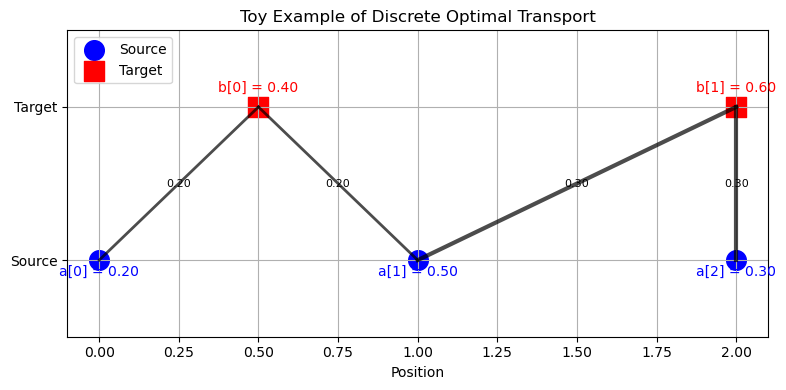

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ot

# ----- Step 1: Define a toy example -----
# Source distribution: three points with weights a_i
X_source = np.array([[0.0], [1.0], [2.0]])   # Source points in 1D
a = np.array([0.2, 0.5, 0.3])                # Their masses (must sum to 1)

# Target distribution: two points with weights b_j
X_target = np.array([[0.5], [2.0]])           # Target points in 1D
b = np.array([0.4, 0.6])                      # Their masses (must sum to 1)

# ----- Step 2: Compute the cost matrix and optimal transport plan -----
# Here we use the Euclidean distance as the cost function
cost_matrix = ot.dist(X_source, X_target, metric='euclidean')
# Compute the optimal transport plan using EMD (Earth Mover's Distance)
plan = ot.emd(a, b, cost_matrix)

print("Cost matrix:")
print(cost_matrix)
print("Optimal transport plan (π):")
print(plan)

# ----- Step 3: Visualization -----
plt.figure(figsize=(8, 4))

# Plot source points on y=0 (blue circles)
plt.scatter(X_source, np.zeros_like(X_source), s=200, c='blue', label='Source')
# Plot target points on y=1 (red squares)
plt.scatter(X_target, np.ones_like(X_target), s=200, c='red', marker='s', label='Target')

# Annotate source and target points with their weights
for i, x in enumerate(X_source):
    plt.text(x, -0.1, f'a[{i}] = {a[i]:.2f}', ha='center', color='blue')
for j, y in enumerate(X_target):
    plt.text(y, 1.1, f'b[{j}] = {b[j]:.2f}', ha='center', color='red')

# Draw lines representing the transport plan
# The line width is scaled by the transport mass for visualization purposes.
for i in range(len(X_source)):
    for j in range(len(X_target)):
        weight = plan[i, j]
        if weight > 1e-4:  # only draw if nonzero (or above a small threshold)
            x_coords = [X_source[i][0], X_target[j][0]]
            y_coords = [0, 1]
            plt.plot(x_coords, y_coords, 'k-', 
                     linewidth=weight * 10,  # scale factor for visibility
                     alpha=0.7)
            # Annotate the edge with the transport weight
            mid_x = (X_source[i][0] + X_target[j][0]) / 2
            mid_y = 0.5
            plt.text(mid_x, mid_y, f'{weight:.2f}', color='black', ha='center', va='center', fontsize=8)

plt.ylim(-0.5, 1.5)
plt.xlabel('Position')
plt.yticks([0, 1], ['Source', 'Target'])
plt.title('Toy Example of Discrete Optimal Transport')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Barycenter mean (for alpha = 0.5): [0.04799969]


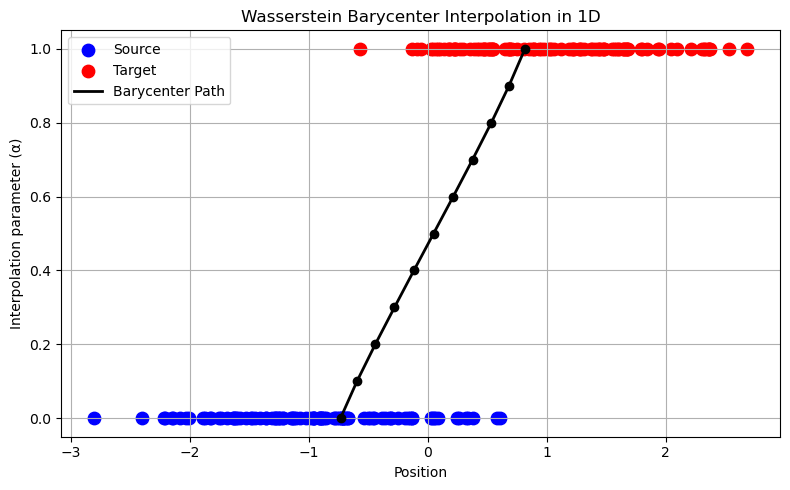

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ot  # POT library: pip install POT
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ----- Step 1: Generate Toy Data -----
np.random.seed(0)
n_source = 100
n_target = 100

# Source distribution: 1D points from a Gaussian centered at -1
X_source = np.random.multivariate_normal(mean=[-1], cov=[[0.5]], size=n_source)
# Target distribution: 1D points from a Gaussian centered at 1
X_target = np.random.multivariate_normal(mean=[1], cov=[[0.5]], size=n_target)

# Uniform weights for each sample (they sum to 1)
a_source = np.ones(n_source) / n_source
b_target = np.ones(n_target) / n_target

# ----- Step 2: Define Common Support -----
# Use the union of source and target samples as the support.
X_support = np.vstack([X_source, X_target])  # shape: (n_support, 1)
n_support = X_support.shape[0]

# Construct source and target distributions over the support:
p_source = np.zeros(n_support)
p_source[:n_source] = a_source

p_target = np.zeros(n_support)
p_target[n_source:] = b_target

# For POT's barycenter function, we need:
# - A: the support, as a (d, n_support) array.
# - M: a (n_support, n_distributions) array where each column is one input distribution.
# Compute pairwise cost matrix over the support
M = ot.dist(X_support, X_support, metric='sqeuclidean')  # shape: (n_support, n_support)

# Stack source and target distributions as columns
A = np.vstack([p_source, p_target]).T  # shape: (n_support, 2)




# ----- Step 3: Compute Barycenter for a Given Interpolation Parameter -----
# We want to compute the barycenter between the source and target distributions with weight vector [1-α, α].
# The barycenter is computed over the fixed support A.
reg = 0.1  # regularization for Sinkhorn
alpha = 0.5  # interpolation parameter; try different values between 0 and 1
weights = np.array([1 - alpha, alpha])  # weights for the two input distributions

# Compute barycenter distribution (a probability vector of length n_support)
p_bary = ot.bregman.barycenter(A, M, reg, weights=weights, numItermax=1000)

# Compute the barycenter’s "mean" as the weighted average of support points:
barycenter_mean = X_support.T @ p_bary  # shape: (1,)
print("Barycenter mean (for alpha = 0.5):", barycenter_mean)

# ----- Step 4: Compute a Sequence of Barycenters -----
alphas = np.linspace(0, 1, 11)
barycenter_means = []
for alpha in alphas:
    weights = np.array([1 - alpha, alpha])
    p_bary = ot.bregman.barycenter(A, M, reg, weights=weights, numItermax=1000)
    bary_mean = X_support.T @ p_bary  # weighted average (1D)
    barycenter_means.append(bary_mean.item())
barycenter_means = np.array(barycenter_means)

# ----- Step 5: Visualization -----
plt.figure(figsize=(8, 5))
plt.scatter(X_source, np.zeros_like(X_source), color='blue', label='Source', s=80)
plt.scatter(X_target, np.ones_like(X_target), color='red', label='Target', s=80)

# Plot barycenter means along the interpolation path
for alpha, bary in zip(alphas, barycenter_means):
    # We'll place these on a line between y=0 and y=1 using alpha as the y-coordinate.
    plt.plot(bary, alpha, 'ko')
plt.plot(barycenter_means, alphas, 'k-', linewidth=2, label='Barycenter Path')

plt.xlabel("Position")
plt.ylabel("Interpolation parameter (α)")
plt.title("Wasserstein Barycenter Interpolation in 1D")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


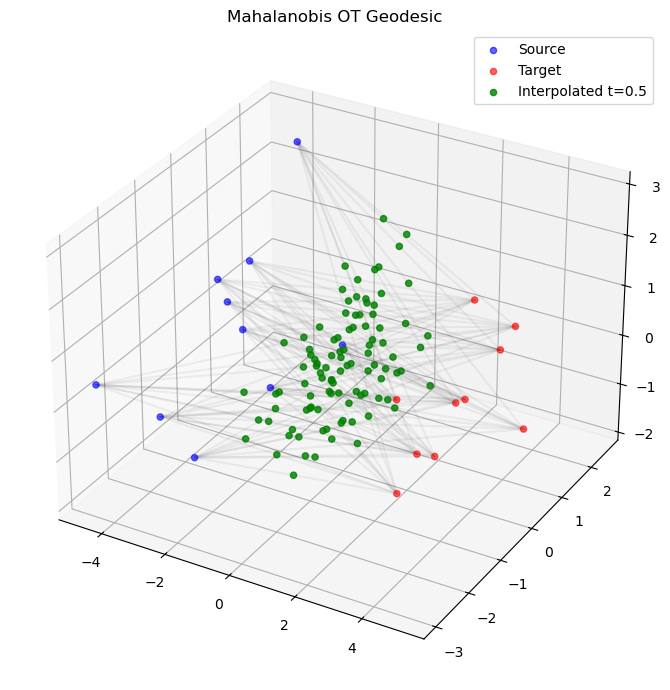

In [5]:
import numpy as np
import torch
import ot
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- [1] Prepare source and target data (e.g. 10D) ---
# Replace this with your actual latent codes
torch.manual_seed(0)
z0 = torch.randn(10, 10)           # source [m, d]
zT = torch.randn(10, 10) + 2.0     # target [n, d]

# Convert to numpy
z0_np = z0.cpu().numpy()
zT_np = zT.cpu().numpy()

# --- [2] Define Mahalanobis matrix ---
# Example: penalize second dimension more
M = np.diag([1.0] + [0.1] * (z0_np.shape[1] - 1))  # shape [d, d]

# Apply transformation: z ↦ M z
z0_M = z0_np @ M
zT_M = zT_np @ M

# --- [3] Compute OT plan using Sinkhorn ---
a = np.ones(len(z0_np)) / len(z0_np)
b = np.ones(len(zT_np)) / len(zT_np)
C_mah = ot.dist(z0_M, zT_M, metric='sqeuclidean')
gamma_mah = ot.sinkhorn(a, b, C_mah, reg=0.1)

# --- [4] Interpolate at a given time t ---
def interpolate_ot(z0, zT, gamma, t=0.5):
    gamma_tensor = torch.tensor(gamma, dtype=torch.float32)
    i_idx, j_idx = torch.nonzero(gamma_tensor, as_tuple=True)
    z_interp = [(1 - t) * z0[i] + t * zT[j] for i, j in zip(i_idx, j_idx)]
    return torch.stack(z_interp), i_idx, j_idx

z_interp, i_idx, j_idx = interpolate_ot(z0, zT, gamma_mah, t=0.5)

# --- [5] Visualize in 3D using PCA ---
def plot_ot_geodesic_3d(z0, zT, z_interp, i_idx, j_idx, t=0.5, title="Mahalanobis OT Geodesic"):
    all_points = torch.cat([z0, zT, z_interp], dim=0).numpy()
    pca = PCA(n_components=3)
    all_pca = pca.fit_transform(all_points)

    m, n = len(z0), len(zT)
    z0_3d = all_pca[:m]
    zT_3d = all_pca[m:m + n]
    interp_3d = all_pca[m + n:]

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(*z0_3d.T, c='blue', label='Source', alpha=0.6)
    ax.scatter(*zT_3d.T, c='red', label='Target', alpha=0.6)
    ax.scatter(*interp_3d.T, c='green', label=f'Interpolated t={t}', alpha=0.8)

    # Optional lines
    for i, j, z_mid in zip(i_idx, j_idx, interp_3d):
        a = z0_3d[i]
        b = zT_3d[j]
        ax.plot([a[0], b[0]], [a[1], b[1]], [a[2], b[2]], 'k-', alpha=0.05)

    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Call the plot
plot_ot_geodesic_3d(z0, zT, z_interp, i_idx, j_idx, t=0.5)


/home/yuen_chen/anaconda3/envs/goat/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


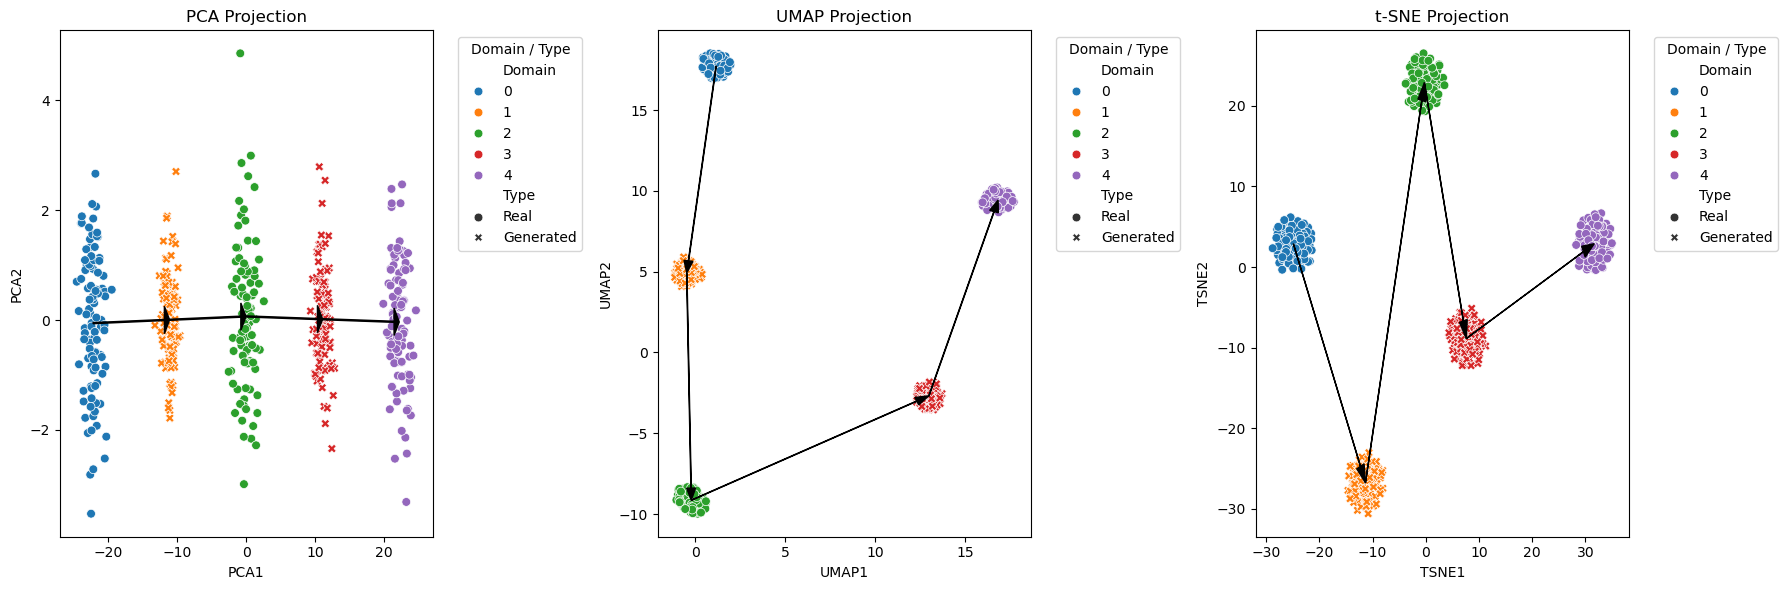

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# ----- Simulate data -----
np.random.seed(42)
num_points, dim = 100, 20

source = np.random.randn(num_points, dim)
mid = np.random.randn(num_points, dim) + 5
target = np.random.randn(num_points, dim) + 10

gen_1 = 0.5 * (source + mid)
gen_2 = 0.5 * (mid + target)

X_data = np.vstack([source, gen_1, mid, gen_2, target])
domain_labels = np.array([0]*num_points + [1]*num_points + [2]*num_points + [3]*num_points + [4]*num_points)
type_labels = (["Real"] * num_points + ["Generated"] * num_points + ["Real"] * num_points +
               ["Generated"] * num_points + ["Real"] * num_points)

df = pd.DataFrame(X_data, columns=[f"X{i}" for i in range(dim)])
df["Domain"] = domain_labels
df["Type"] = type_labels

# ----- Dimensionality Reduction -----
pca = PCA(n_components=2).fit_transform(X_data)
umap_2d = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(X_data)
tsne_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_data)

df["PCA1"], df["PCA2"] = pca[:, 0], pca[:, 1]
df["UMAP1"], df["UMAP2"] = umap_2d[:, 0], umap_2d[:, 1]
df["TSNE1"], df["TSNE2"] = tsne_2d[:, 0], tsne_2d[:, 1]

# ----- Compute Geodesic Points (centroids) -----
def compute_centroids(df, x_col, y_col):
    return df.groupby("Domain")[[x_col, y_col]].mean().reset_index().sort_values("Domain")

pca_centroids = compute_centroids(df, "PCA1", "PCA2")
umap_centroids = compute_centroids(df, "UMAP1", "UMAP2")
tsne_centroids = compute_centroids(df, "TSNE1", "TSNE2")

# ----- Plot Side-by-Side with Geodesic Arrows -----
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PCA
sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="Domain", style="Type",
                ax=axes[0], palette="tab10", s=40)
axes[0].set_title("PCA Projection")
for i in range(len(pca_centroids)-1):
    x0, y0 = pca_centroids.iloc[i][["PCA1", "PCA2"]]
    x1, y1 = pca_centroids.iloc[i+1][["PCA1", "PCA2"]]
    axes[0].arrow(x0, y0, x1-x0, y1-y0, color='black', width=0.02, head_width=0.5, length_includes_head=True)
axes[0].legend(title="Domain / Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# UMAP
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="Domain", style="Type",
                ax=axes[1], palette="tab10", s=40)
axes[1].set_title("UMAP Projection")
for i in range(len(umap_centroids)-1):
    x0, y0 = umap_centroids.iloc[i][["UMAP1", "UMAP2"]]
    x1, y1 = umap_centroids.iloc[i+1][["UMAP1", "UMAP2"]]
    axes[1].arrow(x0, y0, x1-x0, y1-y0, color='black', width=0.02, head_width=0.5, length_includes_head=True)
axes[1].legend(title="Domain / Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# t-SNE
sns.scatterplot(data=df, x="TSNE1", y="TSNE2", hue="Domain", style="Type",
                ax=axes[2], palette="tab10", s=40)
axes[2].set_title("t-SNE Projection")
for i in range(len(tsne_centroids)-1):
    x0, y0 = tsne_centroids.iloc[i][["TSNE1", "TSNE2"]]
    x1, y1 = tsne_centroids.iloc[i+1][["TSNE1", "TSNE2"]]
    axes[2].arrow(x0, y0, x1-x0, y1-y0, color='black', width=0.02, head_width=1.5, length_includes_head=True)
axes[2].legend(title="Domain / Type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


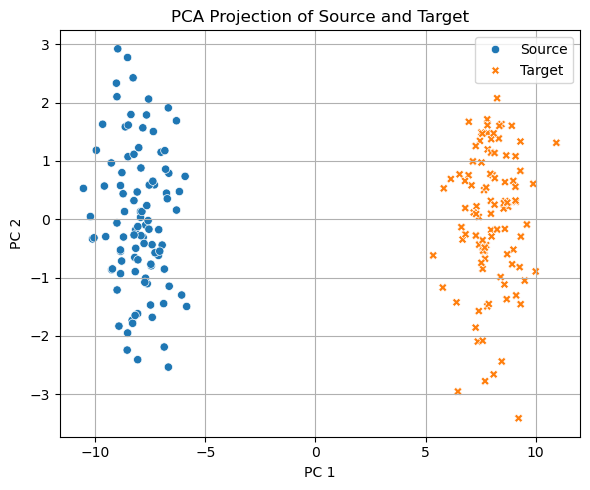

            X0         X1         X2         X3         X4         X5  \
0     0.496714  -0.138264   0.647689   1.523030  -0.234153  -0.234137   
1     1.465649  -0.225776   0.067528  -1.424748  -0.544383   0.110923   
2     0.738467   0.171368  -0.115648  -0.301104  -1.478522  -0.719844   
3    -0.479174  -0.185659  -1.106335  -1.196207   0.812526   1.356240   
4    -0.219672   0.357113   1.477894  -0.518270  -0.808494  -0.501757   
..         ...        ...        ...        ...        ...        ...   
495   9.929780   7.477722   9.848033  11.060144   9.106254   9.612035   
496  11.252284  10.161300  10.644124  10.081989   8.247623   9.139271   
497   8.679122  10.771402  10.001110   8.455566  10.492884  10.833603   
498   9.187454  12.105297  10.034888   8.624489  11.368079  10.125901   
499   9.001559  11.623257  11.991370  10.392914  11.590404   9.430852   

            X6         X7         X8         X9  ...        X18        X19  \
0     1.579213   0.767435  -0.469474   0.5425

In [9]:
# Re-import necessary libraries after kernel reset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ot
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

# Simulate two Gaussian distributions in 10D
np.random.seed(42)
n_samples = 100
dim = 10

mu1 = np.zeros(dim)
mu2 = np.ones(dim) * 5

X = np.random.randn(n_samples, dim) + mu1
Y = np.random.randn(n_samples, dim) + mu2

# Define helper to compute W2 distances under different ground metrics
def compute_wasserstein_distance(X, Y, metric='euclidean'):
    if metric == 'euclidean':
        M = euclidean_distances(X, Y, squared=True)
    elif metric == 'cosine':
        M = cosine_distances(X, Y)
    elif metric == 'manhattan':
        M = np.abs(X[:, None, :] - Y[None, :, :]).sum(axis=2)
    else:
        raise ValueError("Unsupported metric")
    
    a = np.ones((X.shape[0],)) / X.shape[0]
    b = np.ones((Y.shape[0],)) / Y.shape[0]
    W = ot.emd2(a, b, M)
    return W

# Compute distances
w2_euclidean = compute_wasserstein_distance(X, Y, metric='euclidean')
w2_cosine = compute_wasserstein_distance(X, Y, metric='cosine')
w2_manhattan = compute_wasserstein_distance(X, Y, metric='manhattan')

# Visualize projections under PCA
pca = PCA(n_components=2)
XY_pca = pca.fit_transform(np.vstack([X, Y]))
labels = ['Source'] * n_samples + ['Target'] * n_samples

plt.figure(figsize=(6, 5))
sns.scatterplot(x=XY_pca[:, 0], y=XY_pca[:, 1], hue=labels, style=labels, palette='tab10')
plt.title("PCA Projection of Source and Target")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# Prepare a summary table of the distances
import pandas as pd


metrics = ['Euclidean', 'Cosine', 'Manhattan']
distances = [w2_euclidean, w2_cosine, w2_manhattan]
wasserstein_df = pd.DataFrame({'Metric': metrics, 'Wasserstein-2 Distance': distances})

# tools.display_dataframe_to_user(name="Wasserstein Distances", dataframe=wasserstein_df)
print(df)



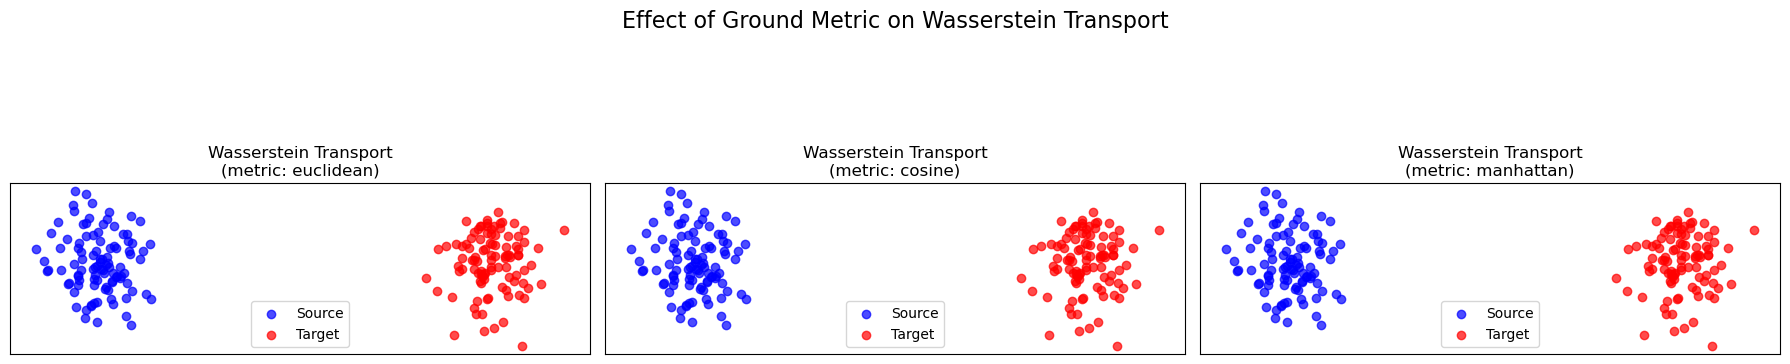

In [12]:
# Redefine the visualize_transport_plan function since it was lost in the reset
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
import ot

def visualize_transport_plan(X, Y, metric, ax):
    if metric == 'euclidean':
        M = euclidean_distances(X, Y, squared=True)
    elif metric == 'cosine':
        M = cosine_distances(X, Y)
    elif metric == 'manhattan':
        M = np.abs(X[:, None, :] - Y[None, :, :]).sum(axis=2)
    else:
        raise ValueError("Unsupported metric")

    a = np.ones((X.shape[0],)) / X.shape[0]
    b = np.ones((Y.shape[0],)) / Y.shape[0]

    gamma = ot.emd(a, b, M)

    XY_pca = pca.transform(np.vstack([X, Y]))
    X_pca = XY_pca[:X.shape[0]]
    Y_pca = XY_pca[X.shape[0]:]

    ax.scatter(X_pca[:, 0], X_pca[:, 1], label='Source', alpha=0.7, color='blue')
    ax.scatter(Y_pca[:, 0], Y_pca[:, 1], label='Target', alpha=0.7, color='red')

    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            if gamma[i, j] > 0.01:
                ax.plot(
                    [X_pca[i, 0], Y_pca[j, 0]],
                    [X_pca[i, 1], Y_pca[j, 1]],
                    color='gray', alpha=gamma[i, j]*5, linewidth=0.5
                )

    ax.set_title(f"Wasserstein Transport\n(metric: {metric})")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.legend()

# Recreate source and target for completeness
np.random.seed(42)
n_samples = 100
dim = 10
X = np.random.randn(n_samples, dim) + 0
Y = np.random.randn(n_samples, dim) + 5

pca = PCA(n_components=2)
pca.fit(np.vstack([X, Y]))

# Plot visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, metric in zip(axes, ['euclidean', 'cosine', 'manhattan']):
    visualize_transport_plan(X, Y, metric, ax)

plt.suptitle("Effect of Ground Metric on Wasserstein Transport", fontsize=16)
plt.tight_layout()
plt.show()


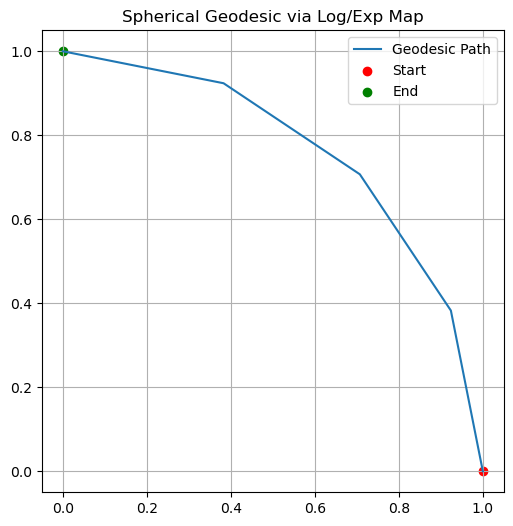

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from geomstats.geometry.hypersphere import Hypersphere

sphere = Hypersphere(dim=2)

# Start and end points on the sphere
x = np.array([1.0, 0.0, 0.0])   # point on equator
y = np.array([0.0, 1.0, 0.0])   # 90° from x

# Log map gives tangent vector from x to y
log_xy = sphere.metric.log(point=y, base_point=x)

# Interpolate along geodesic using exp map
t_vals = np.linspace(0, 1, 5)
geodesic_points = np.array([
    sphere.metric.exp(t * log_xy, base_point=x) for t in t_vals
])

# Plot in 2D (drop z-axis)
x2d = x[:2]
y2d = y[:2]
geodesic_2d = geodesic_points[:, :2]

plt.figure(figsize=(6, 6))
plt.plot(geodesic_2d[:, 0], geodesic_2d[:, 1], label='Geodesic Path')
plt.scatter(*x2d, c='red', label='Start')
plt.scatter(*y2d, c='green', label='End')
plt.gca().set_aspect('equal')
plt.grid(True)
plt.legend()
plt.title("Spherical Geodesic via Log/Exp Map")
plt.show()


2025-03-30 17:07:00.638064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743372420.706853 2722692 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743372420.745903 2722692 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-30 17:07:00.823809: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors :
/usr/bin/ld: cannot find -lnvrtc: No such file or directory
collect2: error: ld returned 1 exit status

OK


/home/yuen_chen/anaconda3/envs/goat/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


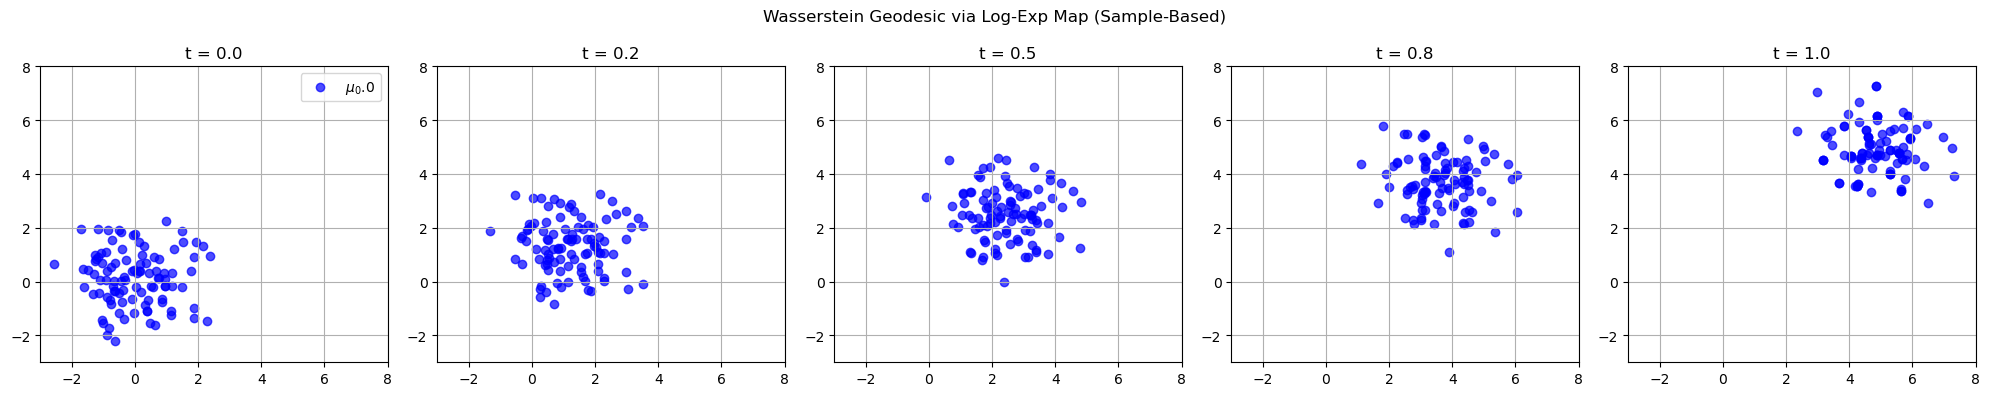

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import ot

# Step 1: Generate two distributions
np.random.seed(0)
n = 100
x = np.random.randn(n, 2)           # Samples from mu_0 (source)
y = np.random.randn(n, 2) + 5       # Samples from mu_1 (target)

# Uniform weights
a = np.ones(n) / n
b = np.ones(n) / n

# Step 2: Compute transport plan (Sinkhorn)
C = ot.dist(x, y, metric='euclidean')**2
gamma = ot.sinkhorn(a, b, C, reg=0.1)  # shape (n, n)

# Step 3: Approximate log-exp transport
def interpolate(x, y, gamma, t):
    """
    Given source x, target y, OT plan gamma, compute interpolated samples at time t.
    """
    x_interp = []
    for i in range(len(x)):
        weights = gamma[i] / np.sum(gamma[i])
        yi = y[np.random.choice(len(y), size=1, p=weights)][0]
        xt = (1 - t) * x[i] + t * yi
        x_interp.append(xt)
    return np.array(x_interp)

# Step 4: Visualize interpolated distributions along the geodesic
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, t in enumerate(np.linspace(0, 1, 5)):
    xt = interpolate(x, y, gamma, t)
    axes[i].scatter(xt[:, 0], xt[:, 1], color='blue', label=f"$\\mu_{t:.1f}$", alpha=0.7)
    axes[i].set_title(f"t = {t:.1f}")
    axes[i].set_xlim(-3, 8)
    axes[i].set_ylim(-3, 8)
    axes[i].grid(True)
    if i == 0:
        axes[i].legend()

plt.suptitle("Wasserstein Geodesic via Log-Exp Map (Sample-Based)")
plt.tight_layout()
plt.show()

